In [1]:
import ssm
from hmmlearn import hmm
from sklearn.decomposition import PCA
from scipy.signal import hilbert

import numpy as np
import matplotlib.pyplot as plt

import mne

import utils.mne_microstates as microstates
from utils import plotter
from utils.utils import load_info, concatenate_gfp, compute_statistics_dataset, load_dataset, smoothing

# Store info for plotting
info = load_info()

n_subj = 44
subjects = np.arange(n_subj) + 1

In [2]:
info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 125.0 Hz
>

In [3]:
subj = '01'
folder = 'data_500_1_100/'
name = folder + f'ss{subj}_clean.set'

In [4]:
original = mne.io.read_raw_eeglab(name, preload=True)

Reading /home/barzon/Microstates/data_500_1_100/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...


In [88]:
original

<RawEEGLAB | ss01_clean.fdt, 64 x 2440000 (4880.0 s), ~1.16 GB, data loaded>

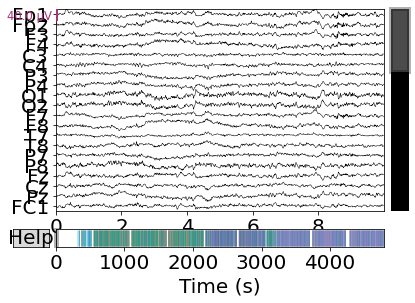

Effective window size : 4.096 (s)


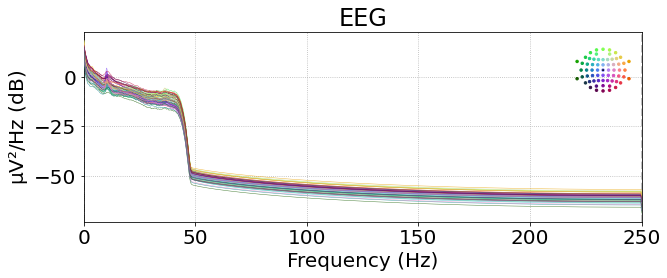

In [65]:
original.plot()
original.plot_psd()
plt.show()

In [5]:
dataset = original.copy().filter(4,30).resample(200).apply_hilbert(envelope=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



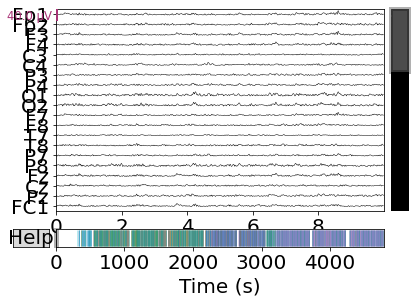

Effective window size : 10.240 (s)


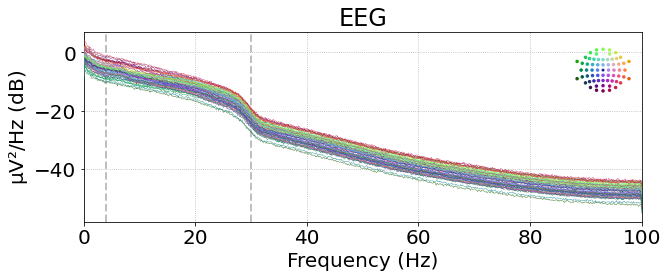

In [67]:
dataset.plot()
dataset.plot_psd()
plt.show()

In [6]:
events, events_id = mne.events_from_annotations(dataset)
end_resting = events[0,0]
print(end_resting)

data = dataset.get_data()
print(data.shape)
data = data[:,:end_resting]
print(data.shape)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
54028
(64, 976000)
(64, 54028)


In [96]:
54028 / 200 / 60

4.5023333333333335

# Moving average

In [7]:
window_size = 20 # 100ms
stride = 5 # 75% overlap

window_avg = [ [np.mean(tmp[i:i+window_size])  for i in range(0, data.shape[1], stride) if i+window_size <= data.shape[1]] for tmp in data]
window_avg = np.array(window_avg)

In [75]:
data.shape[1] / window_avg.shape[1]

5.001354797577303

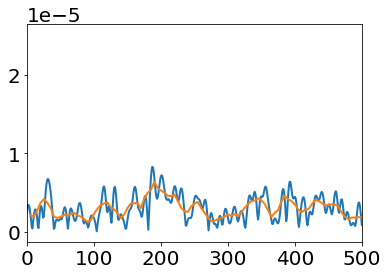

In [8]:
plt.plot(data[0])
plt.plot(np.arange(window_avg.shape[1]) * stride + stride, window_avg[0])

plt.xlim([0, 500])
plt.show()

# Smoothing

In [9]:
smoothed = smoothing(window_avg, sigma=0)

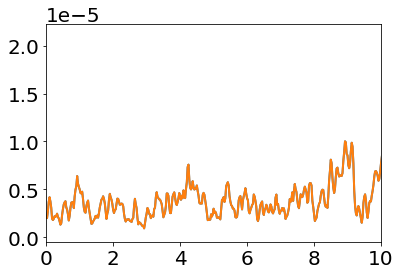

In [10]:
plt.plot(np.arange(window_avg.shape[1]) / 40, window_avg[0])
plt.plot(np.arange(window_avg.shape[1]) / 40, smoothed[0])

plt.xlim([0, 10])
plt.show()

# Standardized

In [11]:
standard = smoothed - np.mean(smoothed)
standard = standard / np.std(standard)

In [127]:
np.save(f'data_hard_preprocess/ss{subj}.npy', standard)

# Hidden Markov Model

In [11]:
model = ssm.HMM(K=6, D=standard.shape[0], observations="gaussian")

In [12]:
hmm_lls = model.fit(datas=standard.T, method="em")

  0%|          | 0/100 [00:00<?, ?it/s]

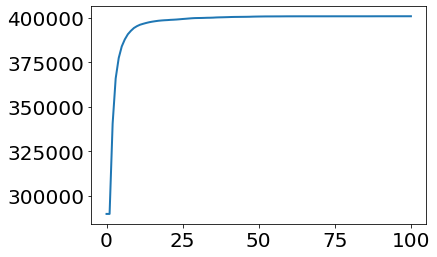

In [13]:
plt.plot(hmm_lls)
#plt.yscale('log')
plt.show()

In [44]:
model.observations.params[1].shape

(6, 64, 64)

In [19]:
model.params[0][0]

array([-1.84206808e+01, -4.99999984e-08, -1.84206808e+01, -1.84206808e+01,
       -1.84206808e+01, -1.84206808e+01])

In [28]:
model.params[1][0]

array([[-0.18657473, -3.36482733, -2.92146731, -3.43402343, -3.95010889,
        -3.49755328],
       [-4.50903982, -0.0682861 , -3.50036632, -5.65711553, -8.22807046,
        -3.86076893],
       [-3.81726829, -2.67518137, -0.17259086, -3.45964438, -6.40755347,
        -3.36546165],
       [-3.47006781, -4.28928383, -3.0032623 , -0.14471335, -4.4644795 ,
        -3.54861514],
       [-3.51371817, -6.78095303, -4.68024891, -3.90673758, -0.11963886,
        -2.94779285],
       [-3.90669755, -3.42097535, -3.77709833, -3.8573131 , -3.51893509,
        -0.13516931]])

In [36]:
model.params[2][0].shape

(6, 64)

TypeError: Invalid shape (64,) for image data

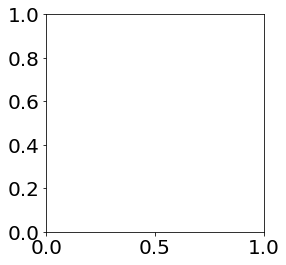

In [37]:
plt.imshow(model.params[2][0][0])

In [59]:
most_likely_states = model.most_likely_states(standard.T)
most_likely_states

array([4, 1, 1, ..., 3, 3, 3])

In [60]:
standard.shape

(64, 12222)

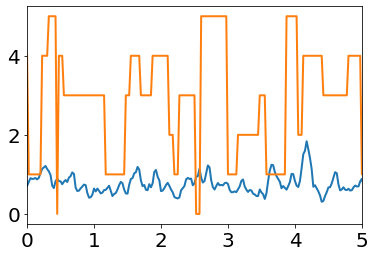

In [61]:
Tmax = 500

plt.plot(np.arange(standard.shape[1])/40, np.std(standard, axis=0))
plt.plot(np.arange(standard.shape[1])/40, most_likely_states)

plt.xlim([0, 5])
plt.show()

In [52]:
1 / 40 * 2

0.05

In [30]:
model

NameError: name 'model' is not defined

# Complete preprocessing

In [85]:
for subj in subjects:
    print(f'\n######## SUBJ {subj} ########')
    
    subj = str(subj)
    if len(str(subj))<2:
        subj = '0' + str(subj)
    
    folder = 'data_500_1_100/'
    name = folder + f'ss{subj}_clean.set'
    
    # Load data
    dataset = mne.io.read_raw_eeglab(name, preload=True)
    dataset = dataset.filter(4,30).resample(200).apply_hilbert(envelope=True)
    
    # Get events
    events, events_id = mne.events_from_annotations(dataset)
    end_resting = events[0,0]
    #print(end_resting)

    # Get resting data
    data = dataset.get_data()
    del dataset
    data = data[:,:end_resting]
    print(data.shape)
    
    # Moving average
    window_size = 20 # 100ms
    stride = 5 # 75% overlap

    data = [ [np.mean(tmp[i:i+window_size])  for i in range(0, data.shape[1], stride) if i+window_size <= data.shape[1]] for tmp in data]
    data = np.array(data)
    
    # Smoothing
    #smoothed = smoothing(window_avg, sigma=10)
    
    # Standardize
    data = data - np.mean(data)
    data = data / np.std(data)
    
    # Store
    np.save(f'data_hard_preprocess/ss{subj}_rest.npy', data)


######## SUBJ 1 ########
Reading /home/barzon/Microstates/data_500_1_100/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
(64, 54028)

######## SUBJ 2 ########
Reading /home/barzon/Microstates/data_500_1_100/ss02_clean.fdt
Reading 0 ... 2213499  =      0.000 ...  4426.998 secs..

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
(64, 54967)

######## SUBJ 11 ########
Reading /home/barzon/Microstates/data_500_1_100/ss11_clean.fdt
Reading 0 ... 2260499  =      0.000 ...  4520.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
(64, 52062)

######## SUBJ 21 ########
Reading /home/barzon/Microstates/data_500_1_100/ss21_clean.fdt
Reading 0 ... 2389999  =      0.000 ...  4779.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin

(64, 53786)

######## SUBJ 30 ########
Reading /home/barzon/Microstates/data_500_1_100/ss30_clean.fdt
Reading 0 ... 2545499  =      0.000 ...  5090.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
(64, 52444)

######## SUBJ 31 ########
Reading /home/barzon/Microstates/data_500_1_100/ss31_clean.fdt
Reading 0 ... 2540499  =      0.000 ...  5

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
(64, 54919)

######## SUBJ 40 ########
Reading /home/barzon/Microstates/data_500_1_100/ss40_clean.fdt
Reading 0 ... 2332999  =      0.000 ...  4665.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-

# Group-level - concatenate, whitening & PCA

In [88]:
### Load data

Tmax = int(1e4)
nmax = 44

data = []

for subj in subjects[:nmax]:
    print(f'\n######## SUBJ {subj} ########')
    
    subj = str(subj)
    if len(str(subj))<2:
        subj = '0' + str(subj)
    
    # Load data
    data_subj = np.load(f'data_hard_preprocess/ss{subj}_rest.npy')
    print(f'shape: {data_subj.shape}')
    
    # Append data
    data.append(data_subj[:,-Tmax:])
    
data = np.concatenate(data, axis=1)
print(f'\nConcatenated data shape: {data.shape}')


######## SUBJ 1 ########
shape: (64, 10802)

######## SUBJ 2 ########
shape: (64, 10163)

######## SUBJ 3 ########
shape: (64, 11511)

######## SUBJ 4 ########
shape: (64, 10910)

######## SUBJ 5 ########
shape: (64, 11866)

######## SUBJ 6 ########
shape: (64, 11528)

######## SUBJ 7 ########
shape: (64, 12106)

######## SUBJ 8 ########
shape: (64, 11333)

######## SUBJ 9 ########
shape: (64, 11221)

######## SUBJ 10 ########
shape: (64, 10990)

######## SUBJ 11 ########
shape: (64, 11687)

######## SUBJ 12 ########
shape: (64, 11092)

######## SUBJ 13 ########
shape: (64, 13947)

######## SUBJ 14 ########
shape: (64, 10501)

######## SUBJ 15 ########
shape: (64, 11227)

######## SUBJ 16 ########
shape: (64, 10526)

######## SUBJ 17 ########
shape: (64, 10657)

######## SUBJ 18 ########
shape: (64, 10889)

######## SUBJ 19 ########
shape: (64, 11080)

######## SUBJ 20 ########
shape: (64, 10409)

######## SUBJ 21 ########
shape: (64, 12548)

######## SUBJ 22 ########
shape: (64, 1044

In [90]:
### Whitening and PCA
n_components = 20
pca = PCA(n_components=n_components, whiten=True)
pca.fit(data.T)

PCA(n_components=20, whiten=True)

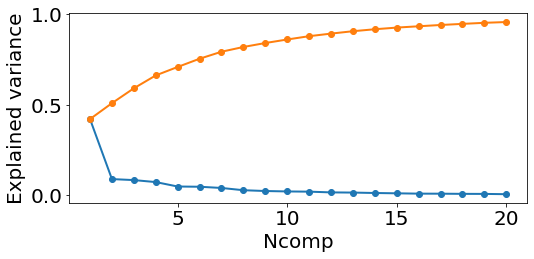

In [93]:
plt.figure(figsize=(8,4))

plt.plot(np.arange(n_components)+1, pca.explained_variance_ratio_, 'o-')
plt.plot(np.arange(n_components)+1, np.cumsum(pca.explained_variance_ratio_), 'o-')

plt.xlabel('Ncomp')
plt.ylabel('Explained variance')

plt.tight_layout()
plt.show()

In [94]:
### Whitening and PCA
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
pca.fit(data.T)

PCA(n_components=10, whiten=True)

In [97]:
print(np.sum(pca.explained_variance_ratio_))

0.8608165077190665


In [102]:
proj = pca.transform(data.T).T
proj.shape

(10, 440000)

In [111]:
np.save(f'data_hard_preprocess/group_pca_white.npy', proj)

In [112]:
proj = np.load(f'data_hard_preprocess/group_pca_white.npy')

In [116]:
pca.get_params(deep=False)

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 10,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': True}

# HMM at group level

In [99]:
#model = ssm.HMM(K=6, D=data.shape[0], observations="gaussian")
#hmm_lls = model.fit(datas=data.T, method="em")

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
model = ssm.HMM(K=6, D=proj.shape[0], observations="gaussian")
hmm_lls = model.fit(datas=proj.T, method="em")

  0%|          | 0/100 [00:00<?, ?it/s]

In [104]:
most_likely_states = model.most_likely_states(proj.T)
most_likely_states

array([1, 1, 1, ..., 3, 3, 3])

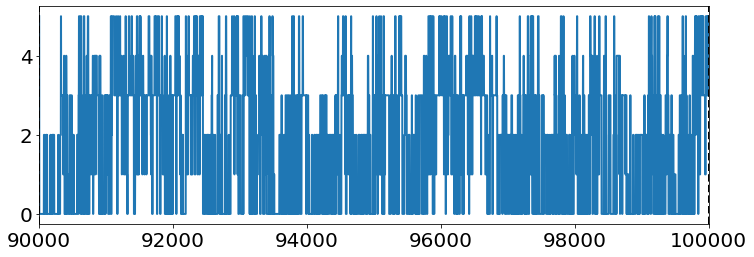

In [108]:
plt.figure(figsize=(12,4))

plt.plot(most_likely_states)

for i in range(nmax+1):
    plt.axvline(i*Tmax, ls='--', c='k')
    
k = 10
plt.xlim((k-1)*Tmax,k*Tmax)
plt.show()

In [109]:
most_likely_states[:100]

array([1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 5, 5, 5, 5, 5, 3, 3, 3, 3])

In [53]:
data_subj.mean()

-3.097733997864197e-16

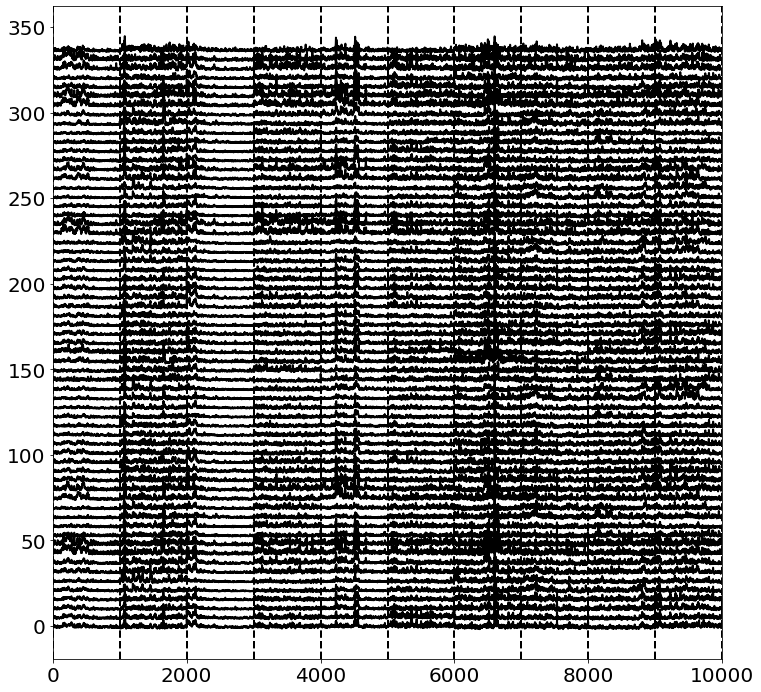

In [75]:
plt.figure(figsize=(12, 12))

for i, tmp in enumerate(data):
    plt.plot(tmp + i*np.max(data)/4, c='k')
    
    plt.axvline(i*Tmax, ls='--', c='k')
    
plt.xlim(0,data.shape[1])
plt.show()

In [110]:
proj.shape

(10, 440000)

# PCA

In [76]:
# Reduce dimensionality with PCA
n_components = 10
pca = PCA(n_components=n_components, whiten=True)

In [77]:
pca.fit(data.T)

PCA(n_components=10, whiten=True)

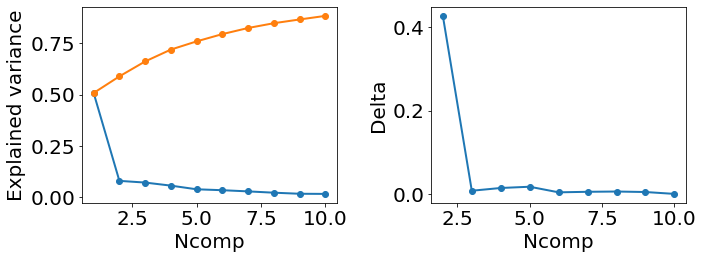

In [78]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.arange(n_components)+1, pca.explained_variance_ratio_, 'o-')
plt.plot(np.arange(n_components)+1, np.cumsum(pca.explained_variance_ratio_), 'o-')

plt.xlabel('Ncomp')
plt.ylabel('Explained variance')

plt.subplot(1,2,2)
plt.plot(np.arange(1, n_components)+1, pca.explained_variance_ratio_[:-1]-pca.explained_variance_ratio_[1:], 'o-')
plt.xlabel('Ncomp')
plt.ylabel('Delta')

plt.tight_layout()
plt.show()

In [79]:
proj = pca.transform(data.T).T
proj.shape

(10, 10000)

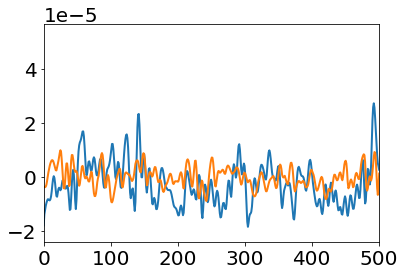

In [101]:
plt.plot(proj[0])
plt.plot(proj[1])

plt.xlim([0,500])
plt.show()

In [102]:
model = ssm.HMM(K=2, D=smoothed.shape[0], observations="gaussian")
hmm_lls = model.fit(datas=smoothed.T, method="em")

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
tt = np.load('data_hard_preprocess/ss01_rest.npy')

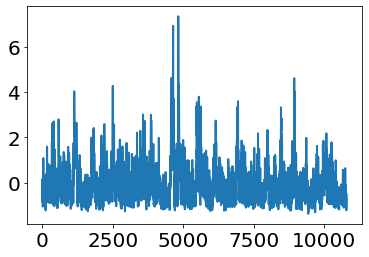

In [4]:
plt.plot(tt[0])

In [9]:
1000 / 40 / 60

0.4166666666666667

In [10]:
model = ssm.HMM(K=4, D=tt.shape[0], observations="gaussian")
hmm_lls = model.fit(datas=tt.T, method="em")

  0%|          | 0/100 [00:00<?, ?it/s]